In [93]:
import torch
import numpy as np
from torch_geometric import utils
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

In [74]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [134]:
# [num_edges, num_edge_features]
edge_attr = torch.tensor([[4,0],[10,0],[3,0],[1,0],[5,0]],dtype=torch.long)

In [135]:
g = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

In [145]:
def get_width(attr):
    return np.sqrt(np.sum(np.square(attr)))

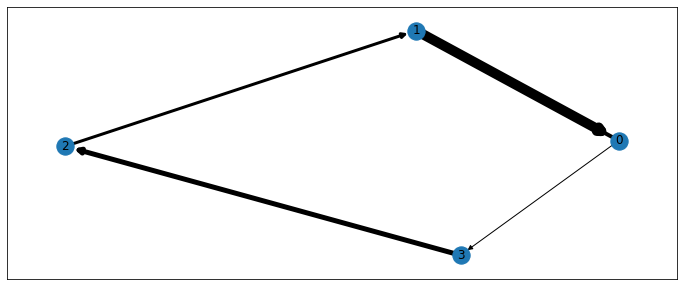

In [146]:
viz = utils.to_networkx(g,edge_attrs=["edge_attr"])
# labels = [i for i in dict(viz.nodes).keys()]
labels = {i:i for i in dict(viz.nodes).keys()}
width = [get_width(i['edge_attr']) for i in dict(viz.edges).values()]
fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(viz)
nx.draw_networkx_nodes(viz, pos, ax = ax, labels=True)
nx.draw_networkx_edges(viz, pos, ax=ax,width=width,style="solid")
_ = nx.draw_networkx_labels(viz, pos, labels, ax=ax)

In [147]:
viz.adj

AdjacencyView({0: {1: {'edge_attr': [4, 0]}, 3: {'edge_attr': [1, 0]}}, 1: {0: {'edge_attr': [10, 0]}}, 2: {1: {'edge_attr': [3, 0]}}, 3: {2: {'edge_attr': [5, 0]}}})